In [35]:
import sys
import os
script_dir = os.getcwd() # coleata o diretorio do projeto atual
sys.path.append(script_dir)

In [36]:
import pandas as pd
import numpy as np
import nltk
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import models, layers
from keras.models import clone_model
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [37]:
data = pd.read_csv(r'CSV\tudo_junto_pp.csv')
data.head(5)

,Ano,Enunciado_Alternativas,Area_de_Conhecimento
0,2020,bienalsur una invitación cruz la front ded señ...,Linguagens
1,2020,españ corazón feder dim una gran sorpr hab pre...,Linguagens
2,2020,dispon httpinversorsaludcom acess 18 ago 2017 ...,Linguagens
3,2020,lo orígen habit expresíon che hay alg má argen...,Linguagens
4,2020,habl con acent andaluz telediari la 9 hac uno ...,Linguagens


In [38]:
areas = data['Area_de_Conhecimento'].unique()
areas

array(['Linguagens', 'Ciências Humanas', 'Ciências da Natureza',
       'Matemática'], dtype=object)

In [39]:
# Passo 1: Defina um mapeamento personalizado
mapa_personalizado = {
    'Linguagens': 0,
    'Ciências Humanas': 1,
    'Ciências da Natureza': 2,
    'Matemática': 3
}

# Passo 2: Substitua os valores na coluna usando o mapeamento
data['Area_de_Conhecimento'] = data['Area_de_Conhecimento'].map(mapa_personalizado)

In [40]:
areas = data['Area_de_Conhecimento'].unique()
areas

array([0, 1, 2, 3], dtype=int64)

In [41]:
# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(data['Enunciado_Alternativas'], data['Area_de_Conhecimento'], test_size=0.2, random_state=1)
X_validation, y_validation = data['Enunciado_Alternativas'], data['Area_de_Conhecimento']

In [42]:
# Vetorização dos textos usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()
X_validation = vectorizer.transform(X_validation).toarray()


In [27]:
# Baixar pacotes necessários
nltk.download('punkt')

# Tokenizar os textos
def tokenize(text):
    if isinstance(text, str):
        return word_tokenize(text.lower())
    return []

# Criar o modelo Word2Vec
def create_word2vec_model(texts, vector_size=100):
    tokenized_texts = [tokenize(text) for text in texts if isinstance(text, str)]
    model = Word2Vec(sentences=tokenized_texts, vector_size=vector_size, window=5, min_count=1, sg=0)
    return model

# Função para obter embeddings Word2Vec
def get_word2vec_embeddings(texts, model):
    embeddings = []
    for text in texts:
        tokens = tokenize(text)
        vectors = [model.wv[token] for token in tokens if token in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(model.vector_size))
    return np.array(embeddings)

# Certifique-se de que X_train e X_test são listas de strings
X_train_texts = [str(text) for text in X_train]
X_test_texts = [str(text) for text in X_test]

# Criar e aplicar o modelo Word2Vec com a dimensão de entrada correta
vector_size = 100  # ou outra dimensão que você deseja
model = create_word2vec_model(X_train_texts, vector_size=vector_size)
X_train_embeddings = get_word2vec_embeddings(X_train_texts, model)
X_test_embeddings = get_word2vec_embeddings(X_test_texts, model)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pichau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
# Converter y_train e y_test para arrays do NumPy e depois aplicar reshape
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
y_validation =  y_validation.values.reshape(-1, 1)

# One-Hot Encoding dos labels
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray()
y_test = ohe.transform(y_test).toarray()
y_validation = ohe.transform(y_validation).toarray()

In [11]:
# Ajustar a função create_model removendo a camada Reshape
def create_deep_model(input_dim, output_dim, dense_layers):
    model = models.Sequential()
    
    # Primeira camada densa com o número de neurônios especificado
    model.add(layers.Dense(dense_layers[0], activation='relu', input_shape=(input_dim,)))

    # Camadas densas subsequentes
    for neurons in dense_layers[1:]:
        model.add(layers.Dense(neurons, activation='relu'))

    # Camada de saída com softmax
    model.add(layers.Dense(output_dim, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [12]:
# Redefine the RNN model with correct input shape
def create_rnn_model(input_dim, output_dim, rnn_units, dense_layers):
    model = models.Sequential()
    
    # Correct input shape: (timesteps, input_dim) - timesteps is 1 in this case
    model.add(layers.SimpleRNN(rnn_units, activation='relu', input_shape=(1, input_dim), return_sequences=True))
    
    # Global average pooling after the RNN layer
    model.add(layers.GlobalAveragePooling1D())
    
    # Dense layers
    for neurons in dense_layers:
        model.add(layers.Dense(neurons, activation='relu'))
    
    # Output layer with softmax activation
    model.add(layers.Dense(output_dim, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [249]:
X_train.shape

(602, 5000)

In [250]:
# Definir os parâmetros do modelo
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
dense_layers = [64, 32, 64]  # Definição do número de neurônios por camada densa

# Criar o modelo usando a função ajustada
model_DEEP = create_deep_model(input_dim, output_dim, dense_layers)


c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [251]:
# Criação do modelo
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
rnn_units = 64   # Número de unidades RNN
dense_layers = [64, 32, 64]  # Número de neurônios em camadas densas

model_RNN = create_rnn_model(input_dim, output_dim, rnn_units, dense_layers)

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [252]:
# Treinamento do modelo
model_DEEP.fit(X_train, y_train, epochs=6, batch_size=32, validation_data=(X_test, y_test))

# Avaliação do modelo
loss, accuracy = model_DEEP.evaluate(X_test, y_test)
print(f'Acurácia no conjunto de teste: {accuracy:.2f}')


Epoch 1/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3453 - loss: 1.3826 - val_accuracy: 0.4371 - val_loss: 1.3534
Epoch 2/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6914 - loss: 1.2994 - val_accuracy: 0.6623 - val_loss: 1.1604
Epoch 3/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9054 - loss: 0.9783 - val_accuracy: 0.7881 - val_loss: 0.7726
Epoch 4/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9809 - loss: 0.4544 - val_accuracy: 0.9007 - val_loss: 0.4399
Epoch 5/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1052 - val_accuracy: 0.9139 - val_loss: 0.3091
Epoch 6/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 0.9007 - val_loss: 0.2840
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.3150 
Acurácia no conjunto de teste: 0.90


In [253]:
# Reshape the input data to add the time step dimension (1 in this case)
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_validation_reshaped = X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))

# Train the RNN model
model_RNN.fit(X_train_reshaped, y_train, epochs=6, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the RNN model
loss, accuracy = model_RNN.evaluate(X_test_reshaped, y_test)
print(f'Acurácia no conjunto de teste: {accuracy:.2f}')

Epoch 1/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3230 - loss: 1.3843 - val_accuracy: 0.3444 - val_loss: 1.3667
Epoch 2/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5419 - loss: 1.3163 - val_accuracy: 0.5894 - val_loss: 1.1745
Epoch 3/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7554 - loss: 0.9477 - val_accuracy: 0.7616 - val_loss: 0.7004
Epoch 4/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9915 - loss: 0.3629 - val_accuracy: 0.8742 - val_loss: 0.3661
Epoch 5/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9944 - loss: 0.0474 - val_accuracy: 0.8940 - val_loss: 0.3351
Epoch 6/6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9139 - val_loss: 0.3099
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9006 - loss: 0.3297 
Acurácia no conjunto de teste: 0.91


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


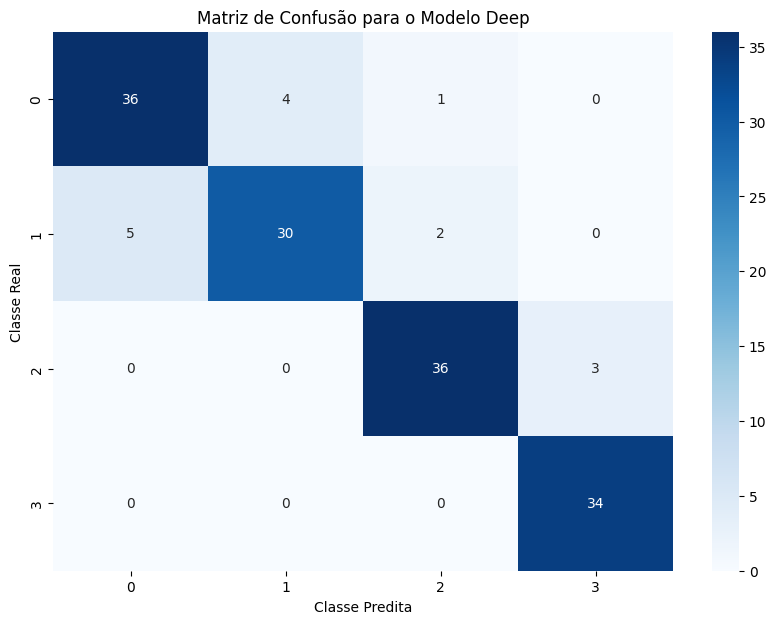

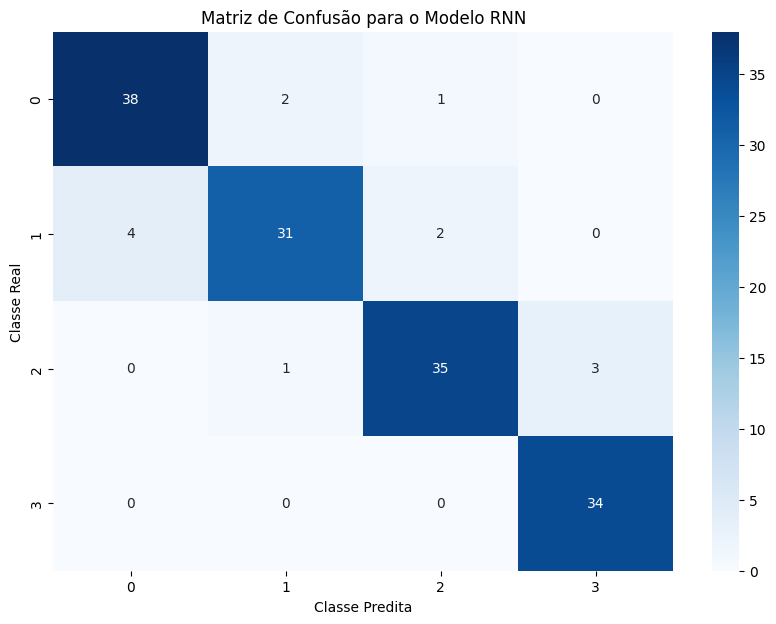

In [254]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Supondo que y_test esteja em formato de uma-hot encoding, converta para rótulos inteiros
if y_test.ndim > 1:  # Checa se y_test é uma matriz (uma-hot encoding)
    y_test = np.argmax(y_test, axis=1)


# Obter previsões para o conjunto de teste
y_pred_deep = model_DEEP.predict(X_test)  # Certifique-se de que 'X_test' é usado para o modelo deep
y_pred_deep_classes = np.argmax(y_pred_deep, axis=1)  # Supondo que você tenha múltiplas classes

y_pred_rnn = model_RNN.predict(X_test_reshaped)  # Certifique-se de que 'X_test_reshaped' é usado para o modelo RNN
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)  # Supondo que você tenha múltiplas classes

# Gerar a matriz de confusão para o modelo deep
cm_deep = confusion_matrix(y_test, y_pred_deep_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_deep, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão para o Modelo Deep')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()

# Gerar a matriz de confusão para o modelo RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão para o Modelo RNN')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


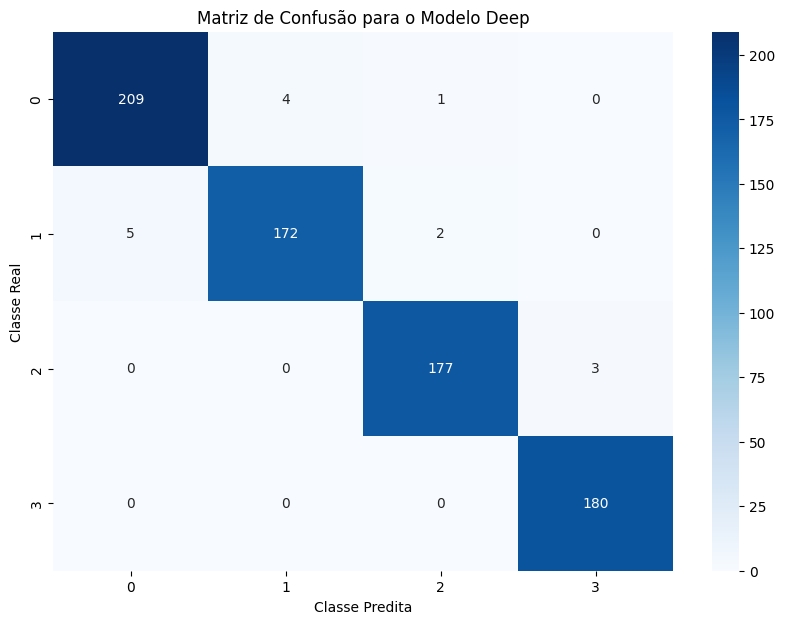

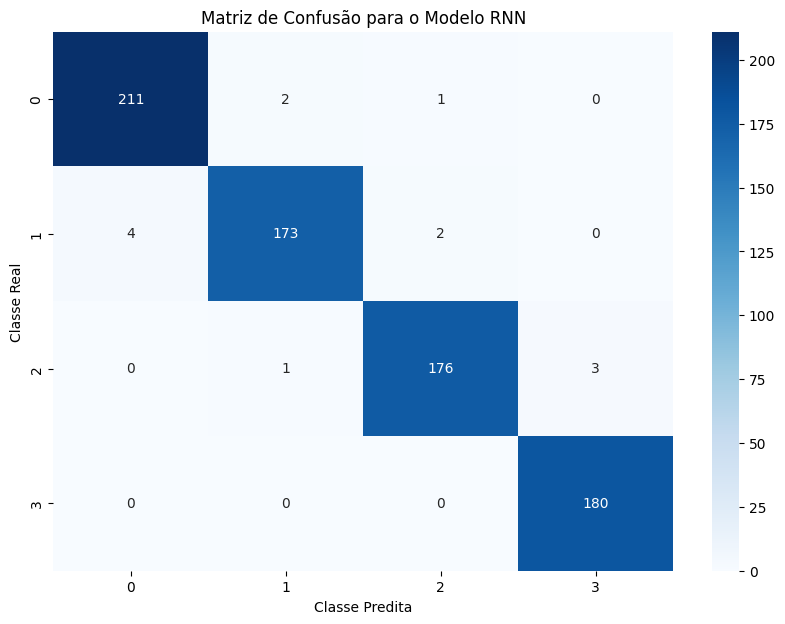

In [255]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

if y_validation.ndim > 1:  # Checa se y_validation é uma matriz (uma-hot encoding)
    y_validation = np.argmax(y_validation, axis=1)

# Obter previsões para o conjunto de teste
y_pred_deep = model_DEEP.predict(X_validation)  # Certifique-se de que 'X_test' é usado para o modelo deep
y_pred_deep_classes = np.argmax(y_pred_deep, axis=1)  # Supondo que você tenha múltiplas classes

y_pred_rnn = model_RNN.predict(X_validation_reshaped)  # Certifique-se de que 'X_test_reshaped' é usado para o modelo RNN
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)  # Supondo que você tenha múltiplas classes

# Gerar a matriz de confusão para o modelo deep
cm_deep = confusion_matrix(y_validation, y_pred_deep_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_deep, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão para o Modelo Deep')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()

# Gerar a matriz de confusão para o modelo RNN
cm_rnn = confusion_matrix(y_validation, y_pred_rnn_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão para o Modelo RNN')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.3150 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9006 - loss: 0.3297 


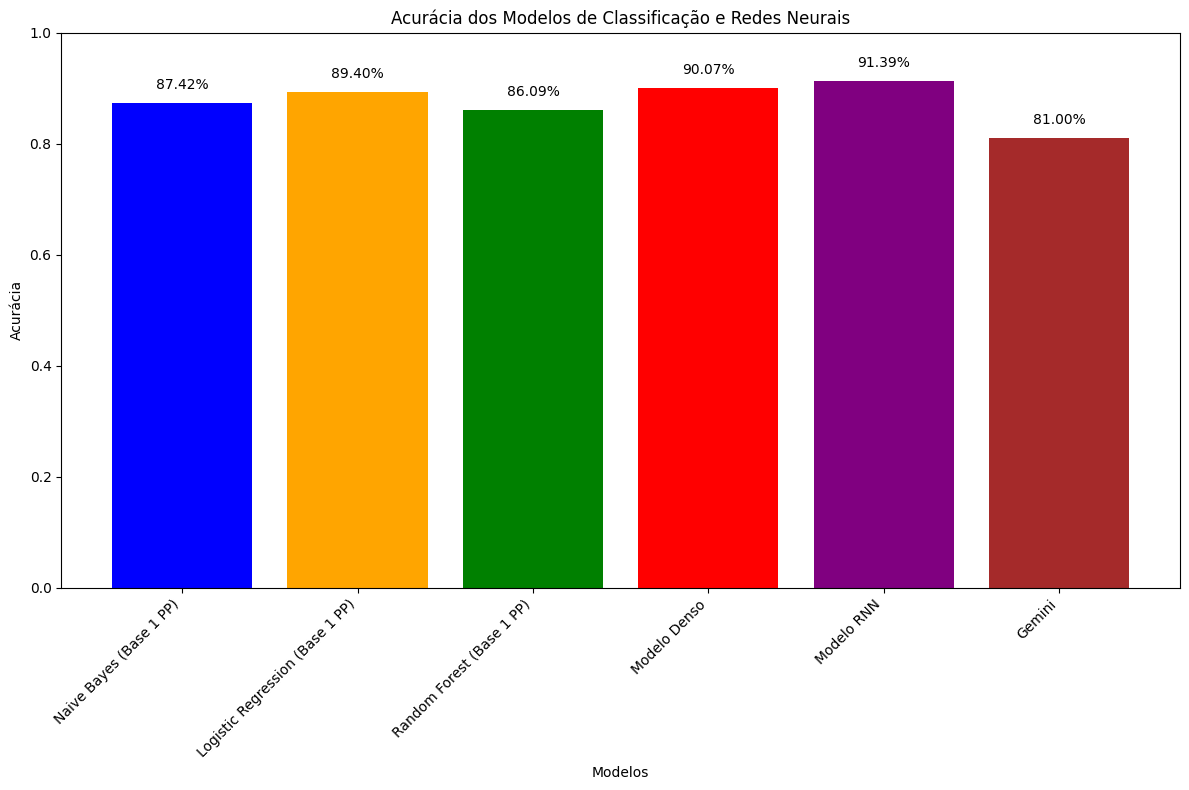

In [256]:
import numpy as np
import matplotlib.pyplot as plt

# Dados de acurácia para os modelos de classificação e redes neurais
model_names = [
    'Naive Bayes (Base 1 PP)', 
    'Logistic Regression (Base 1 PP)', 
    'Random Forest (Base 1 PP)', 
    'Modelo Denso', 
    'Modelo RNN',
    'Gemini'
]

# Supondo que o modelo DEEP foi treinado com one-hot encoding
# Converta y_test para one-hot encoding se necessário
if y_test.ndim == 1:
    y_test_one_hot = ohe.transform(y_test.reshape(-1, 1)).toarray()
else:
    y_test_one_hot = y_test

# Avaliar o modelo denso
loss_deep, accuracy_deep = model_DEEP.evaluate(X_test, y_test_one_hot)

# Avaliar o modelo RNN
loss_rnn, accuracy_rnn = model_RNN.evaluate(X_test_reshaped, y_test_one_hot)

# Acurácias correspondentes
accuracies = [
    0.874172,  # Naive Bayes
    0.894040,  # Logistic Regression
    0.860927,  # Random Forest
    accuracy_deep,  # Modelo Denso (deve ser definido anteriormente)
    accuracy_rnn,  # Modelo RNN (deve ser definido anteriormente)
    0.81
]

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
bars = plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Modelos')
plt.ylabel('Acurácia')
plt.title('Acurácia dos Modelos de Classificação e Redes Neurais')
plt.ylim(0, 1)  # Definir o limite do eixo y de 0 a 1 para acurácia

# Adicionar porcentagens acima das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2%}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos do eixo x para melhor visualização
plt.tight_layout()  # Ajustar o layout para evitar sobreposição

plt.show()


 - Ambiente (Interação com dados)
 - Premiação
 - seleção de escolhas (S, R, A)

In [48]:
from copy import deepcopy

def create_MLP_model(input_dim, output_dim, dense_layers):
    model = models.Sequential()
    
    # Redimensionar os dados de entrada
    model.add(layers.Reshape((input_dim,), input_shape=(input_dim, 1)))
    
    model.add(layers.Dense(dense_layers[0], activation='relu'))

    for neurons in dense_layers[1:]:
        model.add(layers.Dense(neurons, activation='relu'))

    model.add(layers.Dense(output_dim, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

class Genetic_algoritm:
    def __init__(self, tamanho_populacao : int, numero_prog : int, alpha : float, MLPdim : tuple[3], data : tuple[4]) -> None:
        self.tamanho_populacao = tamanho_populacao
        self.numero_prog       = numero_prog
        self.alpha             = alpha
        self.MLPdim            = MLPdim
        self.populacao         = []

        self.X_train = data[0]
        self.Y_train = data[1]
        self.X_test  = data[2]
        self.Y_test  = data[3]

        self.iniciar_gen()
    
    def iniciar_gen(self) -> None:
        for x in range(self.tamanho_populacao): self.populacao.append([create_MLP_model(self.MLPdim[0], self.MLPdim[1], self.MLPdim[2]), 0])

    def pontuador(self, resposta_prevista : int, resposta_real : int) -> int:
        return 1 if resposta_prevista == resposta_real else 0
    
    def avaliador(self, individuo) -> int:
        pontuacao = 0
        resposta_prevista = individuo[0].predict(self.X_train)
        resposta_prevista = np.argmax(resposta_prevista, axis=1)        
        for posicao, pontuacao in enumerate(resposta_prevista): 
            pontuacao += self.pontuador(pontuacao, self.Y_train[posicao])

        return pontuacao
    
    def avaliador_geracional(self) -> None:
        for index, individuo in enumerate(self.populacao): self.populacao[index][1] = self.avaliador(self.populacao[index])
    
    def seleciona_progenitores(self) -> list:
        redes_branch_ordenada = sorted(self.populacao, key=lambda item: item[1], reverse=True)
        return redes_branch_ordenada[:self.numero_prog]
    
    def gerador_descendentes(self) -> None:
        lista_pais   = self.seleciona_progenitores()
        descendentes = self.tamanho_populacao - self.numero_prog
        prox_gen     = []
            
        for x in range(descendentes): prox_gen.append(lista_pais[x % len(lista_pais)])
        for indiv in range(len(prox_gen)):
            prox_gen[indiv][0] = self.mutacao(prox_gen[indiv][0])
            
        self.populacao = prox_gen.extend(lista_pais)
    
    def mutacao(self, individuo):
        rede_mutada = deepcopy(individuo)

        for layer in rede_mutada.layers:
            if len(layer.get_weights()) > 0:
                pesos, biases = layer.get_weights()
                novos_pesos   = pesos + self.alpha * np.random.randn(*pesos.shape)
                
                layer.set_weights([novos_pesos, biases])

        return rede_mutada
    
    def estrategia_evolutiva(self, n_geracoes : int) -> list:
        for x in range(n_geracoes):
            self.avaliador_geracional()
            print(self.populacao)
            self.gerador_descendentes()
            
        return self.populacao[:1]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data['Enunciado_Alternativas'], data['Area_de_Conhecimento'], test_size=0.2, random_state=1)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [45]:
y_train = [x for x in y_train]
y_test = [x for x in y_test]

In [51]:
# self, tamanho_populacao : int, numero_prog : int, alpha : float, MLPdim : tuple[3], data : tuple[4]

tamanho_populacao = 10
numero_prog = 3
alpha = 0.01
rede_neural = (X_train.shape[1], len(areas), [64, 32, 64])
data = (X_train, y_train, X_test, y_test)

algoritimo_genetico = Genetic_algoritm(tamanho_populacao, numero_prog, alpha, rede_neural, data)

In [52]:
algoritimo_genetico.estrategia_evolutiva(5)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[<Sequential name=sequential_70, built=True>, 2], [<Sequential name=sequential_71, built=True>, 3], [<Sequential name=sequential_72, built=True>, 1], [<Sequential name=sequential_73, built=True>, 1], [<Sequential name=sequential_74, built=True>, 1], [<Sequential name=sequential_75, built=True>, 1], [<Sequential name=sequential_76, built=True>, 2], [<Sequential name=sequential_77, built=True>, 1], [<Sequential name=sequential_78, built=True>, 1], [<Sequential name=sequential_79, built=True>, 1]]


ValueError: You cannot add new elements of state (variables or sub-layers) to a layer that is already built. All state must be created in the `__init__()` method or in the `build()` method.